# Analysis

This notebook contains the analysis of the data tracked on
[Weights & Biases](https://wandb.ai/).


## Setup

---

We will first setup everything so that we can easily analyse the experiment
results. This includes importing the necessary libraries, setting paths, loading
the experiment results from W&B.


In [1]:
# ruff: noqa
%load_ext autoreload
%autoreload 2

# Bult-in modules
import os
import sys

sys.path.insert(0, "..")

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# External modules
# - Data Representation
import pandas as pd
import numpy as np

# - Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as pn

# - Machine Learning
import torch
import torch.nn as nn
from sklearn import metrics

# - Experiment Configuration and Logging
import wandb

# Custom modules
from utils import eval_utils as utils

In [2]:
# Setup of global variables
ROOT_DIR = os.path.dirname(os.path.abspath("."))
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "figures")

METHODS = ["baseline", "baseline_pp", "matchingnet", "protonet", "maml"]
METHODS_WITH_SOT = []
for method in METHODS:
    METHODS_WITH_SOT.append(method)
    METHODS_WITH_SOT.append(method + "_sot")

STYLED_METHODS = ["Baseline", "Baseline++", "MatchingNet", "ProtoNet", "MAML"]
STYLED_METHODS_WITH_SOT = []
for method in STYLED_METHODS:
    STYLED_METHODS_WITH_SOT.append(method)
    STYLED_METHODS_WITH_SOT.append(method + " (SOT)")

styled_methods_dict = dict(zip(METHODS, STYLED_METHODS))


def get_name(name, sot=False):
    return styled_methods_dict[name] + (" (SOT)" if sot else "")

In [3]:
# Settings
sns.set_style("dark")
colorstyle = "RdBu"
sns.set_palette(colorstyle)

In [4]:
# Initialize wandb
WANDB_PROJECT = "few-shot-benchmark"
WANDB_ENTITY = "metameta-learners"

# Initialize W&B API
api = wandb.Api()

# Get all runs
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")

## Experiment 1: Benchmark

---

All models on all datasets with and without SOT for fixed few-shot learning
setting (5-way 5-shot).


### Loading Experiment Data


In [5]:
# Get all runs for experiment `benchmark`
GROUP = "benchmark"
USER = "mikasenghaas"

group_runs = [run for run in runs if run.group ==
              GROUP and run.state == "finished"]
print(f"✅ Found {len(group_runs)} runs")

✅ Found 20 runs


Next, we'll load all runs from the given experiment group into a single
dataframe.


In [6]:
df_runs = utils.load_to_df(group_runs)
print(f"✅ Loaded {len(df_runs)} runs.")

df_runs.head()

✅ Loaded 20 runs.


config                                         eval  \
               dataset       method use_sot n_way n_shot   test/acc   
run_id                                                                
tgjtb0j2  tabula_muris  baseline_pp    True     5      5  20.000000   
0c8rhpqd  tabula_muris  baseline_pp   False     5      5  81.880000   
4wr57ehy  tabula_muris     baseline    True     5      5  85.946667   
vmjhuwlq  tabula_muris     baseline   False     5      5  91.186667   
c6kswwrh  tabula_muris         maml    True     5      5  98.520000   

                                                                              \
         train/acc_std val/acc_ci test/acc_std epoch    val/acc train/acc_ci   
run_id                                                                         
tgjtb0j2      0.000000   0.000000     0.000000     4  20.000000     0.000000   
0c8rhpqd      6.139649   0.901880    10.939177     8  82.566667     0.491274   
4wr57ehy      9.385909   0.917272    10.575309     6  87.033333     0.751029   
vmjhuwlq      2.326571   0.716081     7.847196     7  89.293333     0.186164   
c6kswwrh      1.906760   0.234318     2.550085    20  98.106667     0.152573   

                                                        
          train/acc train/loss test/acc_ci val/acc_std  
run_id                                                  
tgjtb0j2  20.000000        NaN    0.000000    0.000000  
0c8rhpqd  96.106667    0.26276    0.875316   11.271153  
4wr57ehy  90.773333   3.185741    0.846201   11.463517  
vmjhuwlq  99.020000   0.125553    0.627906    8.949150  
c6kswwrh  99.240000    0.42473    0.204049    2.928359

### Grouping

Each experiment is uniquely identified by the following parameters:

- `dataset`: The dataset used (`swissprot`, `tabula_muris`)
- `method`: The model used (`baseline`, `baseline_pp`, `protonet`,
  `matchingnet`, `maml`)
- `use_sot`: Whether to include the SOT module (`True`, `False`)
- `n_way`: The number of classes in each episode
- `n_shot`: The number of support samples per class in each episode

For each experiment setting, there are multiple trained models because of
hyper-parameter tuning. We will group the runs by the above parameters and only
use the best-performing model on the validation set for the following analysis.


In [7]:
# Group tuning runs by experiment configuration
df_best_runs = utils.get_best_run(df_runs, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_best_runs)} best runs.")

# Let's also save two separate dataframes for the two different datasets
df_best_runs_tm = df_best_runs[df_best_runs[("config", "dataset")] == "tabula_muris"]
df_best_runs_sp = df_best_runs[df_best_runs[("config", "dataset")] == "swissprot"]

df_best_runs.head()

✅ Filtered to 20 best runs.


config                                         eval  \
               dataset       method use_sot n_way n_shot   test/acc   
tgjtb0j2  tabula_muris  baseline_pp    True     5      5  20.000000   
0c8rhpqd  tabula_muris  baseline_pp   False     5      5  81.880000   
4wr57ehy  tabula_muris     baseline    True     5      5  85.946667   
vmjhuwlq  tabula_muris     baseline   False     5      5  91.186667   
c6kswwrh  tabula_muris         maml    True     5      5  98.520000   

                                                                              \
         train/acc_std val/acc_ci test/acc_std epoch    val/acc train/acc_ci   
tgjtb0j2      0.000000   0.000000     0.000000     4  20.000000     0.000000   
0c8rhpqd      6.139649   0.901880    10.939177     8  82.566667     0.491274   
4wr57ehy      9.385909   0.917272    10.575309     6  87.033333     0.751029   
vmjhuwlq      2.326571   0.716081     7.847196     7  89.293333     0.186164   
c6kswwrh      1.906760   0.234318     2.550085    20  98.106667     0.152573   

                                                        
          train/acc train/loss test/acc_ci val/acc_std  
tgjtb0j2  20.000000        NaN    0.000000    0.000000  
0c8rhpqd  96.106667    0.26276    0.875316   11.271153  
4wr57ehy  90.773333   3.185741    0.846201   11.463517  
vmjhuwlq  99.020000   0.125553    0.627906    8.949150  
c6kswwrh  99.240000    0.42473    0.204049    2.928359

### Train / Val / Test Performance for all models

Here, we plot a simple bar plot for all methods (5 methods, each with and
without SOT) on all three splits (train, val, test). Performances are shown in
two separate plots for Swissprot and Tabula Muris


✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/few-shot-benchmark/figures.


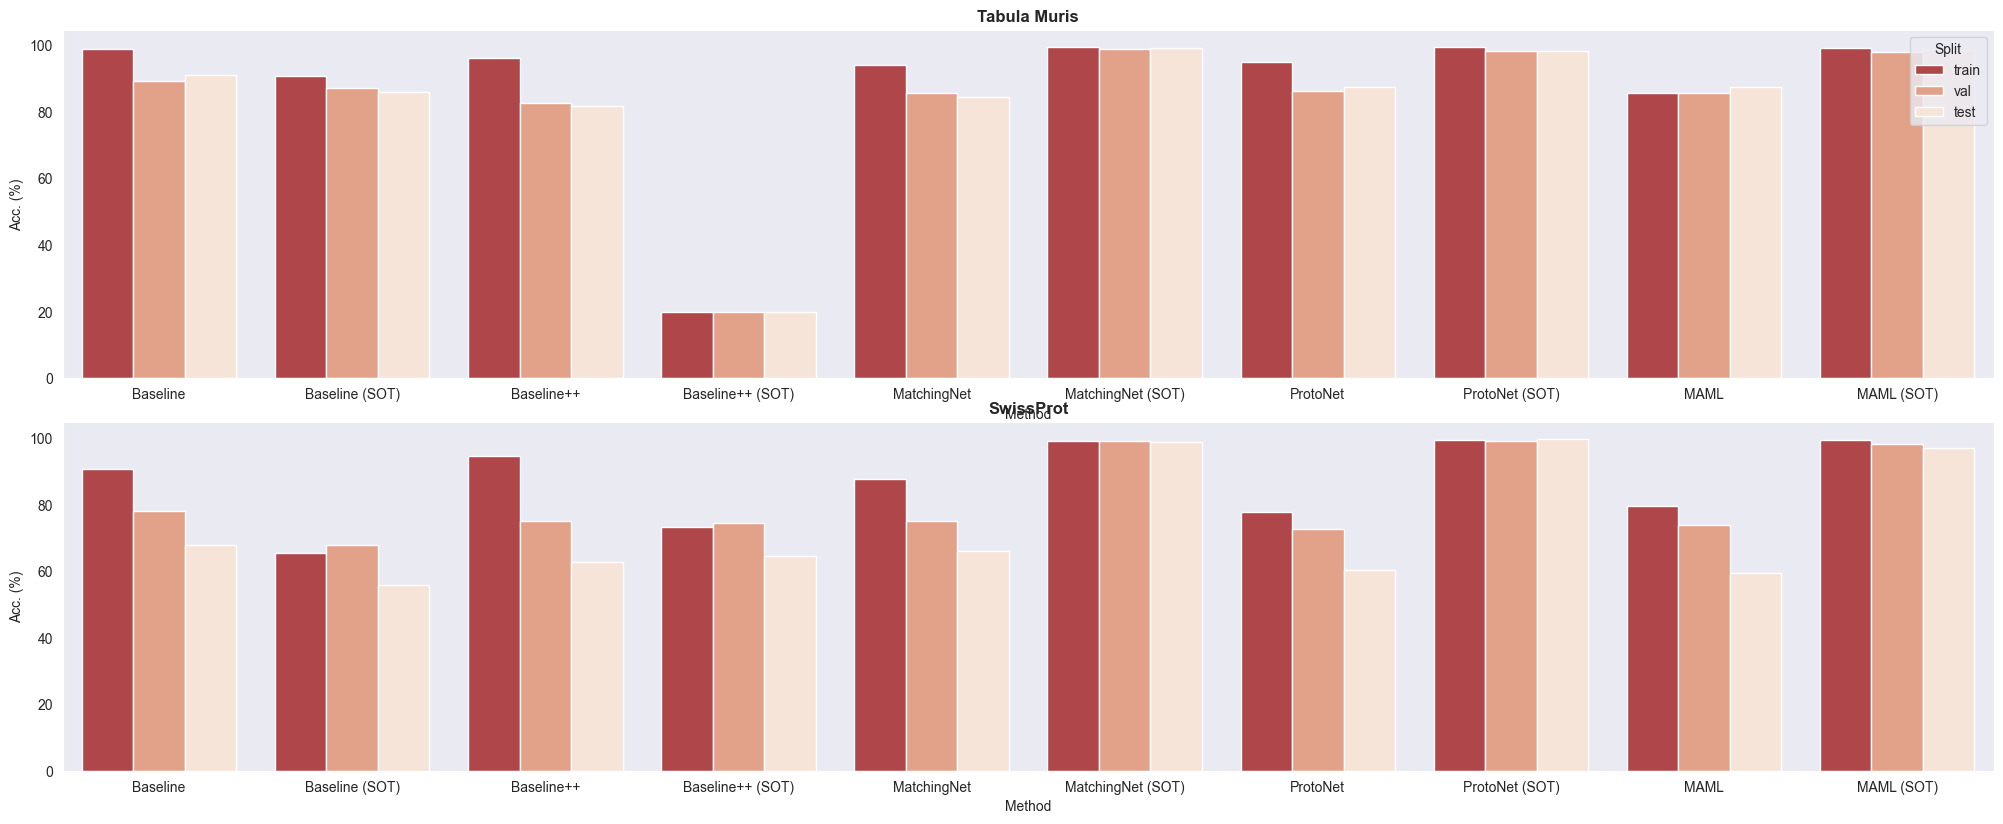

In [8]:
# Performance by split for all methods
fig, axs = plt.subplots(nrows=2, figsize=(20, 8))
fig.tight_layout()


def pivot_acc(df):
    tmp = []
    for i, best_model in df.iterrows():
        for split in ["train", "val", "test"]:
            method_name = get_name(
                best_model[("config", "method")], best_model[("config", "use_sot")]
            )
            tmp.append(
                {
                    "method": method_name,
                    "split": split,
                    "acc": best_model[("eval", f"{split}/acc")],
                }
            )
    return pd.DataFrame(tmp)


sns.barplot(
    pivot_acc(df_best_runs_tm),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[0],
)
sns.barplot(
    pivot_acc(df_best_runs_sp),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[1],
)
# Set title
axs[0].set_title("Tabula Muris", fontweight="bold")
axs[1].set_title("SwissProt", fontweight="bold")

# Disable legend on first subplot
axs[0].get_legend().set_title("Split")
axs[1].get_legend().remove()

for ax in axs:
    ax.set_xlabel("Method")
    ax.set_ylabel("Acc. (%)")

fig.savefig(os.path.join(FIGURE_DIR, "benchmark-split-perf.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Performance by method with and without SOT

Here, we compare the performance of the different methods with and without SOT.
The left subplot shows the test performance on the Tabula Muris dataset, while
the right subplot shows the test performance on the Swissprot dataset.


✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/few-shot-benchmark/figures.


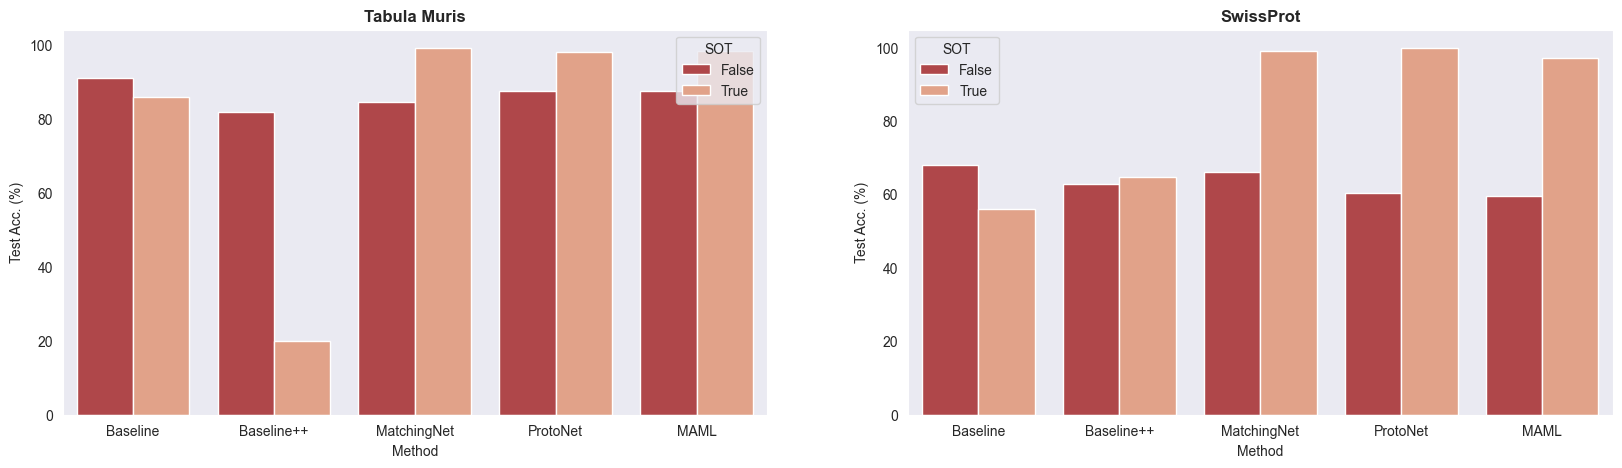

In [9]:
# Performance by method with and without SOT
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

sns.barplot(
    df_best_runs_tm,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    order=METHODS,
    ax=axs[0],
)

sns.barplot(
    df_best_runs_sp,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    ci="sd",
    order=METHODS,
    ax=axs[1],
)

# Set title
axs[0].set_title("Tabula Muris", fontweight="bold")
axs[1].set_title("SwissProt", fontweight="bold")

# Disable legend on first subplot
axs[0].get_legend().set_title("SOT")
axs[1].get_legend().set_title("SOT")

# Set axis labels
axs[0].set_xticklabels([get_name(name.get_text()) for name in axs[0].get_xticklabels()])
axs[1].set_xticklabels([get_name(name.get_text()) for name in axs[1].get_xticklabels()])

for ax in axs:
    ax.set_ylabel("Test Acc. (%)")
    ax.set_xlabel("Method")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "benchmark-perf.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

## Experiment 2: Way-Shot Analysis

---

Varying the number of shots per class.


In [10]:
# Load experiment data for `way-shot` experiment
GROUP = "way-shot"
USER = "mikasenghaas"

# Filter runs by group
group_runs = [run for run in runs if run.group ==
              GROUP and run.state == "finished"]
print(f"✅ Found {len(group_runs)} runs")

✅ Found 50 runs


In [11]:
# Load runs into dataframe
df_runs = utils.load_to_df(group_runs)
print(f"✅ Loaded {len(df_runs)} runs.")

df_runs.head()

✅ Loaded 50 runs.


config                                      eval               \
               dataset    method use_sot n_way n_shot   test/acc train/acc_ci   
run_id                                                                          
1fjek4v6  tabula_muris  protonet    True     2      1  96.716667     0.517496   
onltvph0  tabula_muris  protonet   False     2      1  90.416667     1.080706   
w93rkihk  tabula_muris  protonet    True     2      5  98.966667     0.169342   
12cd0470  tabula_muris  protonet   False     2      5  94.766667     0.677956   
sua9fxt8  tabula_muris  protonet    True     2     10  98.700000     0.171181   

                                                                            \
         train/acc_std train/loss epoch  train/acc test/acc_std    val/acc   
run_id                                                                       
1fjek4v6      6.467354   0.035695     9  97.800000     7.329374  97.083333   
onltvph0     13.506007   1.061035     9  92.433333    15.394579  91.000000   
w93rkihk      2.116339   0.010905    19  99.566667     3.356420  99.333333   
12cd0470      8.472685   0.175386    11  96.883333    10.244294  95.433333   
sua9fxt8      2.139315   0.009217    18  99.700000     5.475095  98.766667   

                                             
         val/acc_ci test/acc_ci val/acc_std  
run_id                                       
1fjek4v6   0.546577    0.586472    6.830792  
onltvph0   1.249900    1.231823   15.620499  
w93rkihk   0.215038    0.268570    2.687419  
12cd0470   0.841047    0.819714   10.510894  
sua9fxt8   0.367951    0.438099    4.598430

Only keep the best run for each experiment configuration. This only has an
effect if hyperparameter tuning was performed.


In [12]:
# Group tuning runs by experiment configuration
df_best_runs = utils.get_best_run(df_runs, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_best_runs)} best runs.")

df_best_runs.head()

✅ Filtered to 50 best runs.


config                                      eval               \
               dataset    method use_sot n_way n_shot   test/acc train/acc_ci   
1fjek4v6  tabula_muris  protonet    True     2      1  96.716667     0.517496   
onltvph0  tabula_muris  protonet   False     2      1  90.416667     1.080706   
w93rkihk  tabula_muris  protonet    True     2      5  98.966667     0.169342   
12cd0470  tabula_muris  protonet   False     2      5  94.766667     0.677956   
sua9fxt8  tabula_muris  protonet    True     2     10  98.700000     0.171181   

                                                                            \
         train/acc_std train/loss epoch  train/acc test/acc_std    val/acc   
1fjek4v6      6.467354   0.035695     9  97.800000     7.329374  97.083333   
onltvph0     13.506007   1.061035     9  92.433333    15.394579  91.000000   
w93rkihk      2.116339   0.010905    19  99.566667     3.356420  99.333333   
12cd0470      8.472685   0.175386    11  96.883333    10.244294  95.433333   
sua9fxt8      2.139315   0.009217    18  99.700000     5.475095  98.766667   

                                             
         val/acc_ci test/acc_ci val/acc_std  
1fjek4v6   0.546577    0.586472    6.830792  
onltvph0   1.249900    1.231823   15.620499  
w93rkihk   0.215038    0.268570    2.687419  
12cd0470   0.841047    0.819714   10.510894  
sua9fxt8   0.367951    0.438099    4.598430

### Shot-Way-Analysis

Display the test/acc as a function of the number of shots per class and the
number of classes to distinguish between the different methods for ProtoNet
without and with SOT.


✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/few-shot-benchmark/figures.


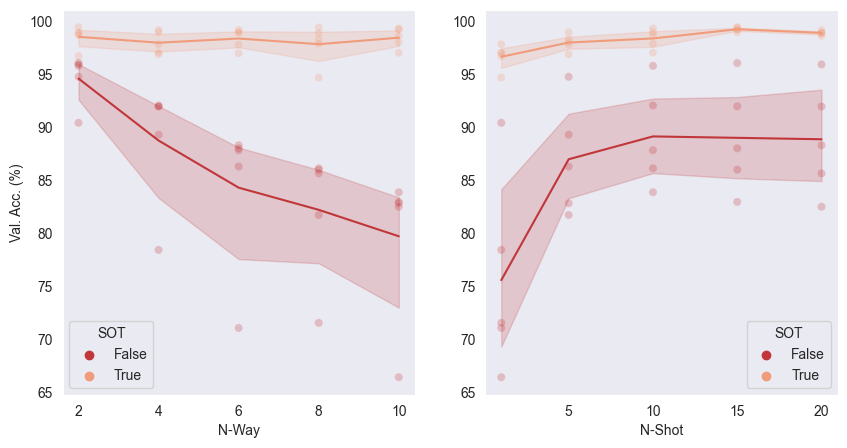

In [13]:
# Plot test/acc vs. n_shot for SOT and non-SOT methods
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# test/acc ~ n_shot
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    ax=axs[0],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[0],
)

# test/acc ~ n_way
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    ax=axs[1],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[1],
)

# Set axis labels
axs[0].set_xlabel("N-Way")
axs[1].set_xlabel("N-Shot")

# Set axis labels
axs[0].set_ylabel("Val. Acc. (%)")
axs[1].set_ylabel("")

# Set legend title
axs[0].get_legend().set_title("SOT")
axs[1].get_legend().set_title("SOT")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "way-shot.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

## Understanding Model Performance


### Looking closer to particular runs

---


Select a run from the table above to look at it in more detail.


In [ ]:
runid = None
config = [run.config for run in group_runs if run.id == runid][0]
dataset, loader, model = utils.init_run(config, ROOT_DIR, "test")

Next, let's evaluate the run's model on the given dataset:


In [ ]:
# Get the mapping from encoding to annotation
encoding2anot = {v: k for k, v in dataset.trg2idx.items()}

# Define metric fn from sklearn assuming y_true and y_pred as input in this order
clf_kwargs = {"average": "macro"}
metric_fns = [
    (metrics.accuracy_score, None),
    (metrics.precision_score, clf_kwargs),
    (metrics.recall_score, clf_kwargs),
    (metrics.f1_score, clf_kwargs),
]

# Evaluate model and obtain its predictions with ground truth for each episode
episodes_results = utils.eval_run(model, loader)

# Compute metrics for each episode
episodes_metrics = utils.compute_metrics(metric_fns, episodes_results)

episodes_metrics.head()